# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

### This assignment is carried out as a part of Applied Data Science Capstone by IBM/Coursera

The aim of this project is to determine/predict the real-estate prices based on the popularity of surrounding venues with the help of data science tools & methods - Location specific data is retrieved with the help of FourSquare API.

In [1]:


!conda install -c conda-forge beautifulsoup4 --yes

!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

print('Libraries installed!')



Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-2.11                  |         openblas          10 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forg

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print('Libraries imported!')

Libraries imported!


# I. Project Summary:

Analyze the following objectives with the help of data science techniques:

    What's the effect of surrounding venues on the real estate prices?
    What are the types of venues that can influence the price & to what extend?
    Can we use the surrounding venue as an estimator to derive the price of a real estate? If yes,how accurate is the estimator?

The data will be:

    Average price of 2-bedrooms condominium  in New York city's neighborhoods. (Scrapped from CityRealty website)
    Venues surrounding each neighborhoods. (FourSquare API)

Target audiences will be:

    Home buyers, who can get the first hand estimate of the value a house in a given location
    Builders, who will make use of these predictions to maximize ROI 
    Residents in a given postcode can use this info to understand the approximate value of their premises

# II. Prepare the data:

URL: https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804

In [3]:


# Using Beautiful Soup to parse the website's html
data = requests.get('https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804').text
soup = BeautifulSoup(data, 'html.parser')



In [4]:
# Scrap the website tables for average prices
areaList = []
neighborhoodList = []

for area in soup.find_all("div", class_="tile _quote _n1 _last"):
    areaText = area.find("a").text
    areaList.append(areaText)
    
for index, table in enumerate(soup.find_all("table", class_="table table-bordered table-hover table-condensed")):
    for row in table.find_all("tr"):
        cells = row.find_all("td")
        if len(cells) > 0:
            neighborhoodName = cells[0].find("a").text.strip()
            avgPrice = cells[3].text.lstrip("$").strip()
            if "K" in avgPrice:
                avgPrice = float(avgPrice.rstrip("K")) * 1000
            else: 
                if "M" in avgPrice:
                    avgPrice = float(avgPrice.rstrip("M")) * 1000000
            
            neighborhoodList.append((
                areaList[index],
                neighborhoodName,
                avgPrice
            ))

In [5]:
# Put the scrapped data into a dataframe
nyc_neighborhoods_df = pd.DataFrame(neighborhoodList)
nyc_neighborhoods_df.columns = ['Area', 'Neighborhood', 'AvgPrice']

In [6]:
print(nyc_neighborhoods_df.shape)
nyc_neighborhoods_df.head()

(54, 3)


,Area,Neighborhood,AvgPrice
0,Brooklyn,Bedford-Stuyvesant,750000
1,Brooklyn,Boerum Hill,1.69e+06
2,Brooklyn,Brooklyn Heights,2.15e+06
3,Brooklyn,Bushwick,967000
4,Brooklyn,Carroll Gardens,1.51e+06


### 2. Get the neighborhoods coordinate:

Free geodata is available free at: https://geo.nyu.edu/catalog/nyu_2451_34572
A copy has been downloaded and stored in IBM cloud

In [8]:
# Download the geodata
!wget -q -O 'nyc_geo.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


In [9]:
# Load the json file
with open('nyc_geo.json') as nyc_geo_json:
    nyc_geo_data = json.load(nyc_geo_json)

In [10]:
# Get the neighborhoods list
nyc_geo_list = nyc_geo_data['features']

# Sample neighborhood node
nyc_geo_list[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [11]:
# Parse the json data into neighborhoods list
neighborhood_geo_list = []
for data in nyc_geo_list:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhood_geo_list.append((
        borough, neighborhood_name, neighborhood_lat, neighborhood_lon
    ))

In [12]:
# Put into a dataframe
neighborhood_geo_df = pd.DataFrame(neighborhood_geo_list)
neighborhood_geo_df.columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# Avg price data is only available for Manhattan and Brooklyn
neighborhood_geo_df = neighborhood_geo_df[(neighborhood_geo_df['Borough'] == 'Manhattan') | (neighborhood_geo_df['Borough'] == 'Brooklyn')]

neighborhood_geo_df.reset_index(drop=True, inplace=True)

In [13]:
print(neighborhood_geo_df.shape)
neighborhood_geo_df.head()

(110, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241


### 3. Combine the two dataframes:

There are three problems here causing the number of neighborhoods doesn't match:

    First, avg price data isn't available to all neighborhoods.
    Second, some neighborhoods name scrapped from the website is not same as their corresponding ones in the geo dataset.
    Third, real estate market names some neighborhoods differently, or make up of new names. All for the purpose of sale.

Each line of price data will be considered, and suitable action will be performed:

    If the names is different, decide which one to use after searching on the internet.
    If the neighborhood is missing from the geo datafram, add it's coordinate.
    If the neighborhoods is makeup, combine them into the larger neighborhood which exist in the geo dataframe.


In [15]:
# Bedford Stuyvesant missing a '-' in the middle
neighborhood_geo_df.at[18, 'Neighborhood'] = 'Bedford-Stuyvesant'

# Downtown is Downtown Brooklyn
neighborhood_geo_df.at[41, 'Neighborhood'] = 'Downtown Brooklyn'

# Dumbo should be DUMBO
neighborhood_geo_df.at[104, 'Neighborhood'] = 'DUMBO'

# Prospect Lefferts Gardens missing a '-' in the middle
nyc_neighborhoods_df.at[15, 'Neighborhood'] = 'Prospect-Lefferts Gardens'
neighborhood_geo_df.at[43, 'Neighborhood'] = 'Prospect-Lefferts Gardens'

# South Slope - Greenwood Heights is just South Slope
nyc_neighborhoods_df.at[17, 'Neighborhood'] = 'South Slope'
# South Slope coordinates is missing
neighborhood_geo_df = neighborhood_geo_df.append({'Borough': 'Brooklyn',
                                                  'Neighborhood': 'South Slope',
                                                  'Latitude': 40.662349, 
                                                  'Longitude': -73.990350}, ignore_index=True)

# Park, Fifth Ave to 79th St is Upper East Side
nyc_neighborhoods_df.at[24, 'Neighborhood'] = 'Upper East Side'

# Flatiron/Union Square is just Flatiron
nyc_neighborhoods_df.at[29, 'Neighborhood'] = 'Flatiron District'
neighborhood_geo_df.at[99, 'Neighborhood'] = 'Flatiron District'

# Gramercy Park is just Gramercy
nyc_neighborhoods_df.at[30, 'Neighborhood'] = 'Gramercy'

# NOHO should be just NoHo
nyc_neighborhoods_df.at[33, 'Neighborhood'] = 'NoHo'
neighborhood_geo_df.at[88, 'Neighborhood'] = 'NoHo'

# NoLiTa/Little Italy is just NoLiTa
nyc_neighborhoods_df.at[34, 'Neighborhood'] = 'NoLiTa'
neighborhood_geo_df.at[76, 'Neighborhood'] = 'NoLiTa'

# SOHO should be just SoHo
nyc_neighborhoods_df.at[35, 'Neighborhood'] = 'SoHo'
neighborhood_geo_df.at[77, 'Neighborhood'] = 'SoHo'

# Stuyvesant Town / PCV is just Stuyvesant Town
nyc_neighborhoods_df.at[36, 'Neighborhood'] = 'Stuyvesant Town'

# Beekman/Sutton Place is just Sutton Place
nyc_neighborhoods_df.at[39, 'Neighborhood'] = 'Sutton Place'

# Midtown East and Midtown West will be combined into Midtown
nyc_neighborhoods_df.at[40, 'Neighborhood'] = 'Midtown'
midtown_avg = (nyc_neighborhoods_df.at[40, 'AvgPrice'] + nyc_neighborhoods_df.at[41, 'AvgPrice']) / 2
nyc_neighborhoods_df.at[40, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[41, 'AvgPrice'] = '-'

# Turtle Bay/United Nations is just Turtle Bay
nyc_neighborhoods_df.at[43, 'Neighborhood'] = 'Turtle Bay'

# Central Harlem is Harlem
neighborhood_geo_df.at[60, 'Neighborhood'] = 'Harlem'

# Lincoln Center is Lincoln Square
nyc_neighborhoods_df.at[51, 'Neighborhood'] = 'Lincoln Square'

# Broadway Cooridor, Central Park West and Riverside Dr./West End Ave. will be combined to Upper West Side
nyc_neighborhoods_df.at[49, 'Neighborhood'] = 'Upper West Side'
midtown_avg = (nyc_neighborhoods_df.at[49, 'AvgPrice'] + nyc_neighborhoods_df.at[50, 'AvgPrice'] + nyc_neighborhoods_df.at[53, 'AvgPrice']) / 3
nyc_neighborhoods_df.at[49, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[50, 'AvgPrice'] = '-'
nyc_neighborhoods_df.at[53, 'AvgPrice'] = '-'

# Drop the Red Hook row
nyc_neighborhoods_df.drop([16], inplace=True)

In [16]:
# Inner join the two dataframes by Neighborhoods
nyc_neighborhood_price_df = pd.concat([nyc_neighborhoods_df.set_index('Neighborhood'), neighborhood_geo_df.set_index('Neighborhood')], axis=1, join='inner')
nyc_neighborhood_price_df.drop(columns=['Area', 'Borough'], inplace=True)
nyc_neighborhood_price_df.reset_index(inplace=True)

In [24]:
# The joined dataframe
print(nyc_neighborhood_price_df.shape)
nyc_neighborhood_price_df.head()

(50, 4)


,Neighborhood,AvgPrice,Latitude,Longitude
0,Bedford-Stuyvesant,750000,40.687232,-73.941785
1,Boerum Hill,1.69e+06,40.685683,-73.983748
2,Brooklyn Heights,2.15e+06,40.695864,-73.993782
3,Bushwick,967000,40.698116,-73.925258
4,Carroll Gardens,1.51e+06,40.680540,-73.994654


### 5. Using FourSquare API to get surrounding venues:

In [25]:
CLIENT_ID = 'DITEDG3SYW1L02UE50LSWIYBBXBAHIAG4IIHKLAM1U1EQGUY' # your Foursquare ID
CLIENT_SECRET = '0AAPLKWZCZAPG3WYSG0ZRNOLFT02RYGNLDGWEEOQSAFBLH4I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DITEDG3SYW1L02UE50LSWIYBBXBAHIAG4IIHKLAM1U1EQGUY
CLIENT_SECRET:0AAPLKWZCZAPG3WYSG0ZRNOLFT02RYGNLDGWEEOQSAFBLH4I


In [26]:
# FourSquare parameters
radius = 1000 # 1 km around the neighborhood center
limit = 200

venues = []

for lat, long, neighborhood in zip(nyc_neighborhood_price_df['Latitude'], nyc_neighborhood_price_df['Longitude'], nyc_neighborhood_price_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [27]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(5000, 7)
There are 337 unique venue types.


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,Bedford-Stuyvesant,40.687232,-73.941785,Sincerely Tommy,40.686066,-73.944294,Boutique
1,Bedford-Stuyvesant,40.687232,-73.941785,Bed-Vyne Brew,40.684751,-73.944319,Bar
2,Bedford-Stuyvesant,40.687232,-73.941785,Bed-Vyne Wine & Spirits,40.684668,-73.944363,Wine Shop
3,Bedford-Stuyvesant,40.687232,-73.941785,The Bush Doctor,40.687399,-73.944480,Juice Bar
4,Bedford-Stuyvesant,40.687232,-73.941785,Peaches HotHouse,40.683331,-73.943853,Fried Chicken Joint


In [28]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# add the neighborhood column
venues_type_onehot['Neighborhood'] = venues_df['Neighborhood']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(5000, 338)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Resta

In [29]:
# get the occurrence of each venue type in each neighborhood
venue_count_df = venues_type_onehot.groupby(['Neighborhood']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(50, 338)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Resta

In [30]:
# get the standardized neighborhoods' average prices
scaler = StandardScaler()
standardized_price = scaler.fit_transform(nyc_neighborhood_price_df[['AvgPrice']])

# add the normalized price to the dataframe
neighborhood_venues_withprice_df = pd.DataFrame(venue_count_df)
neighborhood_venues_withprice_df['StandardizedAvgPrice'] = standardized_price

print(neighborhood_venues_withprice_df.shape)
neighborhood_venues_withprice_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(50, 339)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soba Resta

### <b>III. Analyze the dataframe:</b>

#### <b>1. Validate the correlation between the type of surrounding venues with real estate average price:</b>

In [31]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price
lreg = LinearRegression(normalize=True)

X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)

In [32]:
# let's see how well Linear Regression fit the problem
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max positive coefs:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])
print('Venue types with most postive effect:', X.columns[np.argsort(-lreg.coef_)[:10]].values)
print('Max negative coefs:', lreg.coef_[np.argsort(lreg.coef_)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(lreg.coef_)[:10]].values)
coef_abs = abs(lreg.coef_)
print('Min coefs:', lreg.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

R2-score: -0.042627985568644666
Mean Squared Error: 0.36492986577769415
Max positive coefs: [0.4628269  0.31693487 0.29902821 0.29902821 0.2324017  0.23213134
 0.23213134 0.22685891 0.22411053 0.22378008]
Venue types with most postive effect: ['Shanghai Restaurant' 'Colombian Restaurant' 'Cafeteria' 'Public Art'
 'Botanical Garden' 'Business Service' 'Other Nightlife' 'School'
 'Daycare' 'Library']
Max negative coefs: [-0.22081227 -0.2172643  -0.19821462 -0.19821462 -0.18889432 -0.17735659
 -0.1730037  -0.17102087 -0.17102087 -0.17102087]
Venue types with most negative effect: ['Sports Club' 'Reservoir' 'Street Food Gathering' 'Mini Golf' 'Food'
 'Sports Bar' 'Argentinian Restaurant' 'Office' 'Photography Studio'
 'Flea Market']
Min coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Venue types with least effect: ['Hookah Bar' 'Cemetery' 'Christmas Market' 'State / Provincial Park'
 'TV Station' 'Pakistani Restaurant' 'Factory' 'Music Store'
 'Leather Goods Store' 'Video Store']




The result doesn't look encouraging:

    The R2 score is small.
    There are no really strong coefficient correlations.

Looking back to our dataset, we can see that the features is much bigger than the samples.
PCR (Principal Component Regression) will be used to reduce the number of features.


### <b>2. Applying PCR for better result:</b>

PCR is a regression technique which is based on PCA (Principle Component Analysis).
It's a two steps process:

    First, perform PCA on the features set to obtain the principle components. Then select a subset for the next step.
    Second, use regression on the previous subset of principal components to get a list of coefficient correlations. (Linear Regression will be used)


In [33]:
X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
  


In [34]:
n_component_list = range(1, 51)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

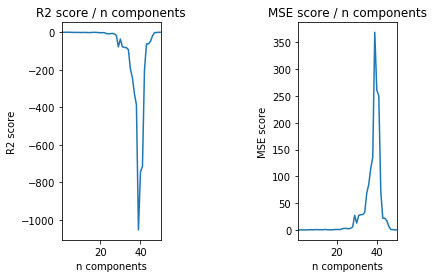

In [35]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [36]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 1 R2 score: 0.35472117102292033
Best n: 1 MSE: 0.22585382294276588


In [37]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: 0.35472117102292033
MSE: 0.22585382294276588




The result is better compared to using simple Linear Regression model

In [38]:
# Let's try to project the coefs back to the original number of features
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

(337,)

In [39]:
# Let's check which venue types effect the most and least
print('Max positive coefs:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('Venue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print('Max negative coefs:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
coef_abs = abs(pcr_coefs)
print('Min coefs:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

Max positive coefs: [0.00571133 0.00540403 0.0050254  0.0046398  0.00457383 0.00446204
 0.00439181 0.00436738 0.00416115 0.0040487 ]
Venue types with most positive effect: ["Women's Store" 'Cycle Studio' 'Hotel' 'Mediterranean Restaurant'
 'Paper / Office Supplies Store' 'Chocolate Shop' 'Clothing Store'
 'Perfume Shop' 'Noodle House' 'Design Studio']
Max negative coefs: [-0.00548597 -0.0050358  -0.00385865 -0.00383215 -0.00380727 -0.00374514
 -0.00372062 -0.00361952 -0.00329387 -0.00326136]
Venue types with most negative effect: ['Deli / Bodega' 'Pizza Place' 'Bar' 'Convenience Store' 'Bagel Shop'
 'Mexican Restaurant' 'Playground' 'Café' 'Thrift / Vintage Store'
 'Music Venue']
Min coefs: [ 2.78486634e-08  1.75834391e-06 -3.44002362e-06 -9.64133392e-06
  1.51611067e-05  2.68963720e-05  2.72175203e-05  2.72175203e-05
 -3.40860501e-05 -3.45505961e-05]
Venue types with least effect: ['Coworking Space' 'Event Space' 'Gaming Cafe' 'Gym Pool'
 'Sculpture Garden' 'Beer Store' 'Ukrainian Res

### <b>IV. Conclusion:</b>

Again, the result doesn't reveal anything promising since the R2 score is still small. The machine learning models can't be used to predict precisely a neighborhood's average house price.

Based on the observed coefficient correlations, fancy places like restaurants seem to boost real estate's value the most.
In some ways, it's a logical conclusion. Neighborhoods that have many restaurants are most likely business areas such as downtown. It's where lots of people go to, lots of activities to enjoy, lots of other businesses, .... The kind of places that people like to live at or closeby.
And as a result of high demand, the price will be higher than other more rural neighborhoods